# LSTM for regional streamflow prediction

Author: Ahmed Elkouk (elkoukah@msu.edu)
Date: 11/07/2024

Modern recurrent neural network (RNN) architectures, such as Long Short-Term Memory (LSTM), have shown great potential across scientific disciplines. In the geosciences, LSTMs offer unprecedented accuracy for prediction of river flows (e.g., Kratzert et al. 2019).

Here, I provide an example of building and training such a model for prediction of streamflow in a given region of the United States. We use meteorological data (daily precipitation, temperature, and solar radiation) and gauged river flow downstream from the CAMELS dataset (Newman et al. 2014) to train our model. CAMELS dataset covers 671 basins across the U.S. with 35 years of daily data.

Kratzert, F., Klotz, D., Herrnegger, M., Sampson, A. K., Hochreiter, S., & Nearing, G. S. (2019). Toward improved predictions in ungauged basins: Exploiting the power of machine learning. Water Resources Research, 55, 11344–11354. https://doi.org/10.1029/2019WR026065

A. Newman; K. Sampson; M. P. Clark; A. Bock; R. J. Viger; D. Blodgett, 2014. A large-sample watershed-scale hydrometeorological dataset for the contiguous USA. Boulder, CO: UCAR/NCAR. https://dx.doi.org/10.5065/D6MW2F4D

In [1]:
# imports
import numpy as np
import xarray as xr
import pandas as pd
import os
import glob
from sklearn import preprocessing
import torch
from torch import nn

## Data

First, the DataModule class is the base class for data which provides data loaders for training and validation. 
The \_\_init\_\_ method is used to prepare the data. This includes downloading and preprocessing if needed. 

In [4]:
class DataModule:
    def __init__(self, root='./', num_workers=4):
        self.root = root
        self.num_workers = num_workers
    
    def get_dataloader(self, train):
        raise NotImplementedError
    
    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)
    
    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

The CAMELS class preprocess and loads training and validation data. During preprocessing, we reshape the input data into (sequence length, number of features), corresponding to (365 days, 5 features). The input data is used to train LSTM to predict streamflow for a single day using the precedent 365 days of 5 meteorological features. Meteorological features and streamflow are split into a training and validation period and standardized for each basin independently using the training period.

Reshaped and standardized meteorological inputs and river flow outputs are wrapped up into Pytorch Dataloader to generate mini-batches for training and validation.

In [ ]:
class CAMELS(DataModule):
    """The CAMELS dataset preprocessing and loading"""
    def __init__(self, batch_size, num_steps, idir_forcings='', idir_streamflow='', ftopo='', dates=[],
                 sel_hucs=[], num_train=0, num_val=0):
        """Initialization and preparation of dataset"""
        super(CAMELS, self).__init__()
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.idir_forcings = idir_forcings
        self.idir_streamflow = idir_streamflow
        self.ftopo = ftopo
        self.sel_hucs = sel_hucs
        self.num_train = num_train
        self.num_val = num_val

        xs_scaled, ys_scaled, xscaler_dict, yscaler_dict = self.build(idir_forcings, idir_streamflow, ftopo, dates, num_steps, sel_hucs)
        self.X = torch.from_numpy(xs_scaled.astype(np.float32))
        self.Y = torch.from_numpy(ys_scaled.astype(np.float32))
        self.scaler = (xscaler_dict, yscaler_dict)
    
    def build(self, idir_forcings, idir_streamflow, ftopo, dates, num_steps, sel_hucs):
        """Prepare dataset"""

        dates_train, dates_val = dates
        ifiles_forcings = glob.glob(idir_forcings+'**/*.txt', recursive=True)
        ifiles_streamflow = glob.glob(idir_streamflow+'**/*.txt', recursive=True)
        df_topo = pd.read_csv(ftopo, delimiter=';', dtype='str')
        index = df_topo['area_gages2'].astype(float) <= 2000 #km2
        basins = df_topo[index]['gauge_id'].values

        # Select basins files 
        ifiles_forc = [ifile for ifile in ifiles_forcings if (os.path.basename(ifile).split('_')[0] in basins)]
        ifiles_stream = [ifile for ifile in ifiles_streamflow if (os.path.basename(ifile).split('_')[0] in basins)]
        # Sort meterological and streamflow files in the same order
        index_f = [os.path.basename(ifile).split('_')[0] for ifile in ifiles_forc]
        index_q = [os.path.basename(ifile).split('_')[0] for ifile in ifiles_stream]
        ifiles_steam_f = list(ifiles_stream[index_q.index(basin)] for basin in index_f)

        xtrain_list, ytrain_list = [], []
        xval_list, yval_list = [], []
        xscaler_dict, yscaler_dict = {}, {}
        i = 0
        for forcingf, streamflowf in zip(ifiles_forc, ifiles_steam_f):
            gauge_id = os.path.basename(streamflowf).split('_')[0]
            huc2 = int(streamflowf.split('/')[-2]) 
            if huc2 in sel_hucs: # select basins in select huc2 regions
                print('processing basin:', gauge_id)
                raw_dfs = self._read(forcingf, streamflowf)
                xtrain, ytrain = self._preprocess(raw_dfs, dates_train, num_steps)
                xval, yval = self._preprocess(raw_dfs, dates_val, num_steps)
                xtrain_scaled, ytrain_scaled, xscaler, yscaler = self._scale(xtrain.reshape(-1, 5), ytrain)
                xval_scaled, yval_scaled = xscaler.transform(xval.reshape(-1, 5)).reshape(xval.shape), yscaler.transform(yval)

                xtrain_list.append(xtrain_scaled.reshape(xtrain.shape))
                ytrain_list.append(ytrain_scaled)
                xval_list.append(xval_scaled)
                yval_list.append(yval_scaled)
                xscaler_dict[gauge_id] = xscaler
                yscaler_dict[gauge_id] = yscaler
                i+=1
        print('preprocessed', i,'basins')

        xtrain_scaled, ytrain_scaled = np.vstack(xtrain_list), np.vstack(ytrain_list)
        xval_scaled, yval_scaled = np.vstack(xval_list), np.vstack(yval_list)
        xs_scaled = np.vstack([xtrain_scaled, xval_scaled])
        ys_scaled = np.vstack([ytrain_scaled, yval_scaled])
        self.num_train = ytrain_scaled.shape[0]
        self.num_val = yval_scaled.shape[0]

        return xs_scaled, ys_scaled, xscaler_dict, yscaler_dict

    def _read(self, ifile_forcing, ifile_streamflow):
        """Read inputs into dataframes"""

        df = pd.read_csv(ifile_forcing, sep='\s+', header=3)
        df_time = df[['Year','Mnth','Day']]
        df_time.columns = ['year','month','day']
        df['time'] = pd.to_datetime(df_time)
        df = df.drop(['Year','Mnth','Day', 'Hr', 'dayl(s)', 'swe(mm)'], axis=1)
        df_meteo = df.set_index('time')

        dfq = pd.read_csv(ifile_streamflow, sep='\s+', 
                        names=['gauge_id', 'year', 'month', 'day', 'Q', 'flag'])
        dfq['time'] = pd.to_datetime(dfq[['year','month','day']])
        dfq = dfq.set_index('time')
        dfq = dfq.drop(['gauge_id', 'year','month','day','flag'], axis=1)

        return df_meteo, dfq
    
    def _preprocess(self, dfs, dates, num_steps):
        """Prepare inputs into arrays"""

        start_date = dates[0] - pd.DateOffset(days=num_steps-1) # for warmup
        end_date = dates[1]
        
        df_meteo, dfq = dfs
        df_meteo = df_meteo[start_date:end_date]
        dfq = dfq[start_date:end_date]
        df_meteo = df_meteo.loc[dfq.index]
        assert dfq.shape[0] == df_meteo.shape[0], f"x: {dfq.shape}, y: {df_meteo.shape} time mismatch"

        index = (dfq>=0).values
        dfq = dfq[index]
        df_meteo = df_meteo[index]
        # reshape into a format appropriate for training x(nseq, num_steps, n_features), y(nseq, 1)
        nseq = df_meteo.shape[0] - num_steps + 1
        x = np.stack([df_meteo.values[i:i+num_steps] for i in range(nseq)])
        y = dfq.values[num_steps-1:]

        return x, y

    def _scale(self, x, y):
        """Inputs standarization"""

        xscaler = preprocessing.StandardScaler().fit(x)
        yscaler = preprocessing.StandardScaler().fit(y)
        x_scaled = xscaler.transform(x)
        y_scaled = yscaler.transform(y)

        return x_scaled, y_scaled, xscaler, yscaler
    
    def get_dataloader(self, train):
        """Dataloader for training and validation"""
        idx = slice(0, self.num_train) if train else slice(
            self.num_train, self.num_train + self.num_val)
        return self.get_tensorloader([self.X, self.Y], train, idx)

## Model

ProgressBoard (https://d2l.ai/) allows us to plot progress interactively while model training is going on. 

In [6]:
from ProgressBoard import ProgressBoard

Module, a subclass of the base nn.Module class of neural networks in PyTorch, is the base class of the models we want to implement. The training_step and validation_step will be called during training to provide the loss. Model weights are updated to minimize the loss.

In [7]:
class Module(nn.Module):
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.plot_train_per_epoch = plot_train_per_epoch
        self.plot_valid_per_epoch = plot_valid_per_epoch
        self.board = ProgressBoard()
    
    def loss(self, yhat, y):
        raise NotImplementedError
    
    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is not defined'
        return self.net(X)
    
    def plot(self, key, value, train):
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / self.trainer.num_train_batches
            n = self.trainer.num_train_batches / self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / self.plot_valid_per_epoch
        self.board.draw(x, value.to(torch.device('cpu')).detach().numpy(),
                        ('train_' if train else 'val_') + key, every_n=int(n))
    
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l
    
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

We define RNN as the parent class for the LSTM model. Then, we build our own custom LSTM_camels model. 

In [9]:
class RNN(Module):
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

class LSTM(RNN):
    def __init__(self, num_inputs, num_hiddens):
        Module.__init__(self)
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs):
        return self.rnn(inputs)

In [ ]:
class LSTM_camels(Module):
    """ Custom LSTM for CAMELS"""
    def __init__(self, rnn, num_inputs, num_hiddens, lr=0.01):
        super().__init__()
        self.rnn = rnn
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.lr = lr
        self.init_params()

    def init_params(self):
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.LazyLinear(1)

    def forward(self, X):
        rnn_outputs, (h_out, _) = self.rnn(X)
        h_last = self.dropout(rnn_outputs[:,-1,:])
        return self.linear(h_last)

    def loss(self, y_hat, y):
        fn = nn.MSELoss()
        return fn(y_hat, y)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)


## Training

The Trainer class provides functions for training and validation: training_step() and validation_step(). It also puts model and input data on GPUs to accelerate training. 

In [12]:
class Trainer:
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.max_epochs = max_epochs
        self.num_gpus = num_gpus
        self.gradient_clip_val = gradient_clip_val
        #assert num_gpus == 0, 'No GPU support yet'
        self.gpus = [torch.device(f'cuda:{i}') for i in range(min(self.num_gpus, torch.cuda.device_count()))]
    
    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader) if self.val_dataloader is not None else 0)
    
    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        if self.gpus:
            model.to(self.gpus[1])
        self.model = model
    
    def prepare_batch(self, batch):
        if self.gpus:
            batch = [a.to(self.gpus[1]) for a in batch]
        return batch
    
    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
    
    def fit_epoch(self):
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1
    
    def clip_gradients(self, grad_clip_val, model):
        return torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_val)

## Prediction

Putting everthing together, we prepare the inputs (here for the Colorado river as an example), initialize the model, and perform the training.

In [ ]:
# Dataset
idir_forcings = '/mnt/scratch/elkoukah/0_data/CAMELS/basin_dataset_public_v1p2/basin_mean_forcing/daymet/'
idir_streamflow = '/mnt/scratch/elkoukah/0_data/CAMELS/basin_dataset_public_v1p2/usgs_streamflow/'
ftopo = '/mnt/scratch/elkoukah/0_data/CAMELS/camels_topo.txt'
dates = [(pd.to_datetime("1980-10-01"), pd.to_datetime("1995-09-30")),
        (pd.to_datetime("1995-10-01"), pd.to_datetime("2010-09-30"))] # Training and validation periods
sel_hucs = [14] # Colorado river basin
camels = CAMELS(1024, 365, idir_forcings=idir_forcings, idir_streamflow=idir_streamflow, ftopo=ftopo, dates=dates, 
                sel_hucs=sel_hucs)

processing basin: 09210500
processing basin: 09223000
processing basin: 09065500
processing basin: 09378170
processing basin: 09035900
processing basin: 09047700
processing basin: 09081600
processing basin: 09066300
processing basin: 09066000
processing basin: 09378630
processing basin: 09035800
processing basin: 09352900
processing basin: 09107000
processing basin: 09066200
processing basin: 09034900
processing basin: 09312600
processing basin: 09306242
preprocessed 17 basins


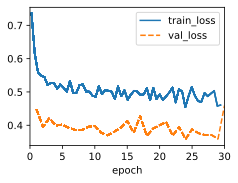

In [15]:
# Model init
lstm = LSTM(num_inputs=5, num_hiddens=256)
model = LSTM_camels(lstm, num_inputs=5, num_hiddens=256, lr=5e-3)

# Training
trainer = Trainer(max_epochs=30, gradient_clip_val=0, num_gpus=2)
trainer.fit(model, camels)

## Evaluation

A subclass of CAMELS provides testing data for each basin.

In [47]:
class CAMELS_basin(CAMELS):
    """Preprocessing CAMELS dataset for basin-level prediction"""
    def __init__(self, batch_size, num_steps, idir_forcings='', idir_streamflow='', ftopo='', dates=[],
                 gauge_ids=[], scaler=(None, None), num_train=None, num_val=None):
        self.batch_size = batch_size
        self.X_dict, self.Y_dict = self.build(idir_forcings, idir_streamflow, ftopo, dates, num_steps, gauge_ids, scaler)

    def build(self, idir_forcings, idir_streamflow, ftopo, dates, num_steps, gauge_ids, scaler):

        ifiles_forcings = glob.glob(idir_forcings+'**/*.txt', recursive=True)
        ifiles_streamflow = glob.glob(idir_streamflow+'**/*.txt', recursive=True)
        df_topo = pd.read_csv(ftopo, delimiter=';', dtype='str')
        index = df_topo['area_gages2'].astype(float) <= 2000
        basins = df_topo[index]['gauge_id'].values
        ifiles_forc = [ifile for ifile in ifiles_forcings if (os.path.basename(ifile).split('_')[0] in basins)]
        ifiles_stream = [ifile for ifile in ifiles_streamflow if (os.path.basename(ifile).split('_')[0] in basins)]
        index_f = [os.path.basename(ifile).split('_')[0] for ifile in ifiles_forc]
        index_q = [os.path.basename(ifile).split('_')[0] for ifile in ifiles_stream]
        ifiles_steam_f = list(ifiles_stream[index_q.index(basin)] for basin in index_f)

        xscaler_dict, yscaler_dict = scaler
        xdict, ydict = {}, {}
        for forcingf, streamflowf in zip(ifiles_forc, ifiles_steam_f):
            gauge_id = os.path.basename(streamflowf).split('_')[0]
            if gauge_id in gauge_ids:
                print('processing:', gauge_id)
                raw_dfs = self._read(forcingf, streamflowf)
                x, y = self._preprocess(raw_dfs, dates, num_steps)
                xs_scaled = xscaler_dict[gauge_id].transform(x.reshape(-1,5)).reshape(x.shape)
                ys_scaled = yscaler_dict[gauge_id].transform(y)
                xdict[gauge_id] = torch.from_numpy(xs_scaled.astype(np.float32))
                ydict[gauge_id] = torch.from_numpy(ys_scaled.astype(np.float32))

        return xdict, ydict

    def get_dataloader(self, train):
        """Defined in :numref:`subsec_partitioning-seqs`"""
        idx = slice(0, None)
        loader_dict = {gauge_id:self.get_tensorloader([self.X_dict[gauge_id], self.Y_dict[gauge_id]], train, idx) for gauge_id in self.X_dict.keys()}
        return loader_dict

In [49]:
idir_forcings = '/mnt/scratch/elkoukah/0_data/CAMELS/basin_dataset_public_v1p2/basin_mean_forcing/daymet/'
idir_streamflow = '/mnt/scratch/elkoukah/0_data/CAMELS/basin_dataset_public_v1p2/usgs_streamflow/'
ftopo = '/mnt/scratch/elkoukah/0_data/CAMELS/camels_topo.txt'
dates = [pd.to_datetime("1995-10-01"), pd.to_datetime("2010-09-30")]
test_gauges = ['09210500']
camels_bw = CAMELS_basin(256, 270, idir_forcings=idir_forcings, idir_streamflow=idir_streamflow, 
                         ftopo=ftopo, dates=dates, gauge_ids=test_gauges, scaler=camels.scaler)

processing: 09210500


In [50]:
nse = []
model.eval()
with torch.no_grad():
    yscaler_dict = camels.scaler[1]
    loader_dict = camels_bw.get_dataloader(train=False)
    for gauge_id in loader_dict.keys():
        temp_yhat, temp_yobs = [], []
        for batch in loader_dict[gauge_id]:
            xs_basin, ys_basin = batch
            xs = xs_basin.to(trainer.gpus[1])
            y_hat = model(xs)

            y_hat = yscaler_dict[gauge_id].inverse_transform(y_hat.cpu().numpy())
            y_obs = yscaler_dict[gauge_id].inverse_transform(ys_basin.cpu().numpy())
            y_hat[y_hat<0] = 0
            temp_yhat.append(y_hat)
            temp_yobs.append(y_obs)
        yhat = np.vstack(temp_yhat)
        yobs = np.vstack(temp_yobs)
        nse_basin = 1-np.mean((yhat-yobs)**2 / (np.std(yobs))**2)
        nse.append(nse_basin)

In [51]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Basin 09210500 - Test set NSE: 0.287')

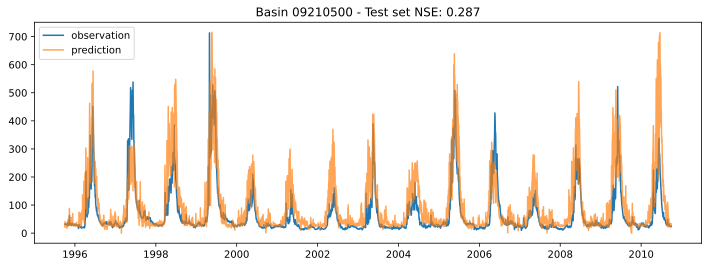

In [52]:
date_range = pd.date_range(*dates)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(date_range, yobs, label="observation")
ax.plot(date_range, yhat, alpha=.7, label="prediction")
ax.legend()
ax.set_title(f"Basin {test_gauges[0]} - Test set NSE: {nse[0]:.3}")